## 目錄
- Step 0. Loading dataset
- Step 1. Data preprocessing
    - Step 1.1 Creating Training and Testing sets
    - Step 1.2 Scaling data
    - Step 1.3 define sliding window function 
- Step 2. Build model
    - Step 2.1 Build Model
    - Step 2.2 Setting optimizer and make compile
    - Step 2.3 Training model
    - Step 2.4 model summary
- Step 3. Plotting predictions from the network
    - plot dataset
- Practice
    - 把Open、High、Low、Close跟Volume都當Feature

In [ ]:
enable_model_list = {'lstm':False, 'conv1d':False, 'xgb':True}

# import package

這份文件的資料集是Tesla從2014年到2017的股票歷史。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Step 0. Loading dataset

In [3]:
tesla_stocks = pd.read_csv('dataset/tesla_stocks.csv')

In [4]:
# 資料共有六個資訊，日期、開盤、當日最高、當日最低、收盤、成交量
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,4-Aug-14,234.38,240.50,233.27,238.52,5967406
1,5-Aug-14,237.47,242.99,235.69,238.49,5388581
2,6-Aug-14,238.90,251.42,238.58,248.93,9249265
3,7-Aug-14,250.12,256.69,249.12,252.39,7478926
4,8-Aug-14,251.16,251.76,246.50,248.13,5099061


## Step 1. Data preprocessing

In [5]:
# 簡化預測複雜度，我們只使用收盤價預測
data_to_use = tesla_stocks['Close'].values

In [6]:
# 資料共有756天成交紀錄
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1.1 Creating Training and Testing sets
分割資料時，必須要在進行標準化之前進行分割。因為標準化會基於所有資料點調整資料分佈，但我們希望測試資料不會受到訓練資料的任何影響。

#### Note: 在做資料處理之前先分割資料很重要，不要汙染測試集。

In [7]:
data_to_use = tesla_stocks['Close'].values

In [8]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1.2 Scaling data

In [9]:
# 使用sklearn套件將資料標準化(mean = 0, std = 1)
scaler = StandardScaler()

In [10]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

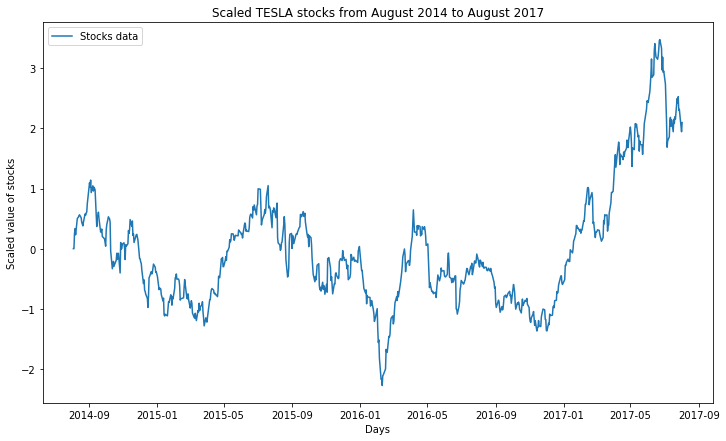

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(12, 7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date, scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

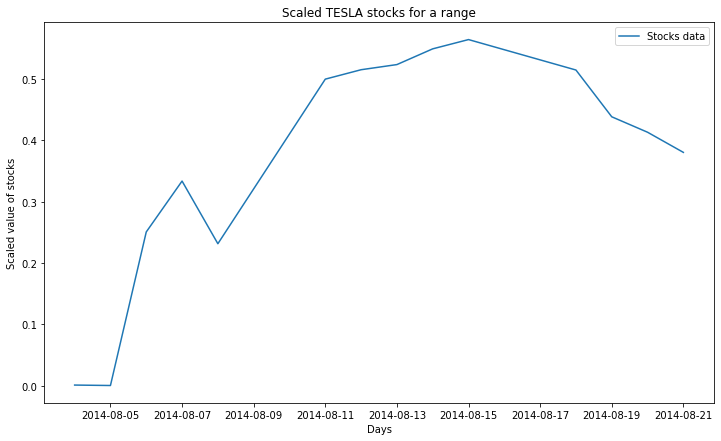

In [12]:
a = 0
b = 14
register_matplotlib_converters()

tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(12, 7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks for a range')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date[a:b], scaled_dataset[a:b], label='Stocks data')
plt.legend()
plt.show()

In [13]:
# import numpy as np  
# import matplotlib.pyplot as plt
# a = 9
# for i in range(a**2):
#     plt.subplot(a,a,i+1)  
#     plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelleft=False,  
#     labelbottom=False) 
#     plt.plot(tesla_stocks.Date[7*(i):14+7*i], X[i], label = '')  



### Step 1.3 define sliding window function 

In [14]:
# 抓取window_size-1的資料作為觀察資料(x), 下一天作為預測資料(y)


def window_data(data, window_size, stride):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += stride
    X = np.array(X)
    y = np.array(y)
    assert len(X) == len(y)
    return X, y

In [15]:
window_size = 14
stride = 1
X, y = window_data(scaled_dataset, window_size, stride)

In [16]:
# days = int(0.9*len(X))
days = 700
X_train = np.array(X[:days])
y_train = np.array(y[:days])

X_test = np.array(X[days:])
y_test = np.array(y[days:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 14, 1)
y_train size: (700, 1)
X_test size: (42, 14, 1)
y_test size: (42, 1)


In [17]:
print(X_test.shape)
print(X_train.shape)

(42, 14, 1)
(700, 14, 1)


### 計算分數

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
def score(y_true, y_pred):
# y_true = y_train
# y_pred = clf.predict(X_train)
    print('---')
    print('R2, ', r2_score(y_true, y_pred))
    print('mse, ', mse(y_true, y_pred))
    print('mae, ', mae(y_true, y_pred))
    print('rmse, ', mse(y_true, y_pred) ** 0.5)
    print('---')

## Model1: Zero-Rule model

In [20]:
y_pred = [y_train.mean()]

print('train')
score(y_train, y_pred*len(y_train))
print('test')
score(y_test, y_pred*len(y_test))

train
---
R2,  0.0
mse,  0.6230737216460739
mae,  0.6222525420387317
rmse,  0.789350189488844
---
test
---
R2,  -26.695887720394605
mse,  7.993274659519818
mae,  2.7757280020086172
rmse,  2.827237991312337
---


## Model2: Moving Average
對每一個短序列取平均

In [21]:
Xm = np.concatenate((X_train, X_test), axis=0)
Xm.shape

(742, 14, 1)

In [22]:
def Moving_average(data, window_size, stride):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size].mean())
#         y.append(data[i:i+window_size].mean())
        i += stride
    X = np.array(X)
#     y = np.array(y)
#     assert len(X) == len(y)
    return X
ym = Moving_average(Xm, 7, 1)
ym.shape

(735,)

## Model3: Stacked LSTM

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.layers import TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def LSTM_def():
    print('lstm def...')
    inputs = Input(shape=(window_size, 1))
    lstm1 = LSTM(units=16*3, activation='relu', return_sequences=True)(inputs)
    lstm2 = LSTM(units=16*3, activation='relu', return_sequences=False)(lstm1)
    lstm2 = Dropout(0.2)(lstm2)
    flat = Flatten()(lstm2)
    outputs = Dense(units=1)(flat)

    model = Model(name = 'StackedLSTM',inputs=inputs, outputs=outputs)

#     model.summary()
    return model
def LSTM_train_score(X_train, y_train):
    model = LSTM_def()
    opt = Adam(lr=0.001, decay=1e-6, clipvalue=5)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    model.fit(X_train, y_train, epochs=100, verbose = False)
    score(y_train, model.predict(X_train))
    return model

## Model4: Conv1D

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Activation, Conv1D, Flatten
import tensorflow.keras as keras
def Conv1d_def():
    print('conv1d def...')
    model = Sequential()
    # inputs = Input(shape=(window_size,))
    model.add(Conv1D(input_shape=(window_size, 1), filters = 16, kernel_size=3, strides=1, \
                     activation='relu'))
    model.add(Conv1D(filters = 16, kernel_size=3, strides=1, \
                     activation='relu'))
    model.add(Flatten()) #由於前面兩個conv1D的Kerner size都是3，所以原本長度是7的資料會變成3，而channels為16，所以一起攤平變成48
    model.add(Dense(1)) #輸出一個值
#     print(model.input_shape) #可以把輸入的型態秀出來
#     model.summary()
    return model
def Conv1d_train_score(X_train, y_train):
    Conv1d = Conv1d_def()
    opt = keras.optimizers.Adam(lr=0.001, decay=1e-6, clipvalue=5)

    Conv1d.compile( loss='mse', optimizer=opt, metrics=['mse'] )
    Conv1d.fit(X_train, y_train, epochs=100, verbose = False)
    
    y_pred=Conv1d.predict(X_train)
    
    score(y_train, y_pred)
    return Conv1d


## numpy squeeze
後面的模型需要把資料降維

In [39]:
# y_train.reshape(-1,1)
y_train.shape
# np.squeeze(y_train).shape
y_train[:10]
np.squeeze(y_train)[:10]
X_train.shape
np.squeeze(X_train).shape

red_X_train = np.squeeze(X_train)
red_y_train = np.squeeze(y_train)
red_X_test = np.squeeze(X_test)
red_y_test = np.squeeze(y_test)

In [40]:
# red_X_train = pd.DataFrame(red_X_train)
# red_X_train['pred'] = red_y_train
# red_X_train.corr()

In [41]:
# import seaborn as sns; sns.set()

# ax = sns.heatmap(red_X_train.corr())

### 單純猜前一天的收盤價

In [42]:
# # y_train_pred = []
# y_test_pred = []
# for i in range(len(X_test)):
#     y_test_pred.append(X_test[i][-1])

# y_pred = np.array(y_test_pred)
# score(y_test, y_pred)

## Model5: XGBoost reg

In [43]:
import xgboost as xgb

def XGB_def():
    print('xgb def...')
    xgbreg = xgb.XGBRegressor(
    #樹的個數
    n_estimators=1000,
    # 如同學習率
    learning_rate= 0.3, 
    # 構建樹的深度，越大越容易過擬合    
    max_depth=6, 
    # 隨機取樣訓練樣本 訓練例項的子取樣比
    subsample=1, 
    # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子
    gamma=0, 
    # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。
    reg_lambda=1,  
    #隨機種子
    seed=1000, 
    # L1 正則項引數
#        reg_alpha=0,
    #設定成1則沒有執行資訊輸出，最好是設定為0.是否在執行升級時列印訊息。
    silent=0 ,
#     tree_method = 'gpu_hist', 
#     predictor = 'gpu_predictor',
    eval_metric= 'mse',
    objective = 'reg:squarederror'
    )
    
    return xgbreg

# 定義xgb
def XGB_train_score(X_train, y_train):
    # 定義模型
    xgbreg = XGB_def()
    
    # 模型 訓練
    xgbreg.fit(X_train,y_train,eval_metric='rmse')

    # 預測值
    y_pred=xgbreg.predict(X_train)

    # 評估
    score(y_train, y_pred)
    return xgbreg

In [44]:
XGB_train_score(red_X_train, red_y_train)

xgb def...
---
R2,  0.9999976821996309
mse,  1.4441605019809127e-06
mae,  0.0008410994301076246
rmse,  0.001201732292143684
---


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mse', gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1000, silent=0, subsample=1, verbosity=1)

In [45]:
def metric_model(func, X_train, y_train, X_test, y_test):
    model = func(X_train, y_train)
    print('y_test')
    score(y_test, model.predict(X_test))
    return model
# metric_model(XGB_train_score, red_X_train, red_y_train, red_X_test, red_y_test)

## Step 3. Plotting predictions from the network

In [46]:
def encode_data2plot(model, X_train, X_test):
    # Training set預測結果
    training_set_pred = np.array([])

    training_set_pred = model.predict(X_train)

    # Testing set預測結果
    testing_set_pred = model.predict(X_test)
    
    # 把資料放到list裡面準備畫圖
    # 因為我們是用前七天預測第8天股價，故前七天設為None
    training = [None]*window_size
    for i in range(len(X_train)):
        training.append(training_set_pred[i])

    testing = [None] * (window_size + len(X_train))
    testing_loss = 0
    for i in range(len(X_test)):
        testing.append(testing_set_pred[i])
        training.append(None)
#         testing_loss += (testing_set_pred[i] - y_test[i])**2
#     print('testing_loss:', testing_loss / len(X_test))
    return training, testing

In [47]:
# # Training set預測結果
# training_set_pred = np.array([])

# training_set_pred = conv1d.predict(X_train)

# # Testing set預測結果

# testing_set_pred = conv1d.predict(X_test)

In [48]:
# # 把資料放到list裡面準備畫圖
# # 因為我們是用前七天預測第8天股價，故前七天設為None
# training = [None]*window_size
# for i in range(len(X_train)):
#     training.append(training_set_pred[i])
    
# testing = [None] * (window_size + len(X_train))
# testing_loss = 0
# for i in range(len(X_test)):
#     testing.append(testing_set_pred[i])
#     training.append(None)
#     testing_loss += (testing_set_pred[i] - y_test[i])**2
# print('testing_loss:', testing_loss / len(X_test))

In [49]:
Zero_y_pred = [y_train.mean()]*len(scaled_dataset)

In [50]:
# mvAve = Moving_average(Xm, 7, 1)
# len(scaled_dataset)

In [51]:
# training = xgbreg.predict(red_X_train)
# print(training.shape)
# testing = xgbreg.predict(red_X_test)
# print(testing.shape)

### plot dataset

xgb def...
---
R2,  0.9999976821996309
mse,  1.4441605019809127e-06
mae,  0.0008410994301076246
rmse,  0.001201732292143684
---
y_test
---
R2,  -0.6314173554124005
mse,  0.4708412720967292
mae,  0.5477936767386078
rmse,  0.6861787464624135
---


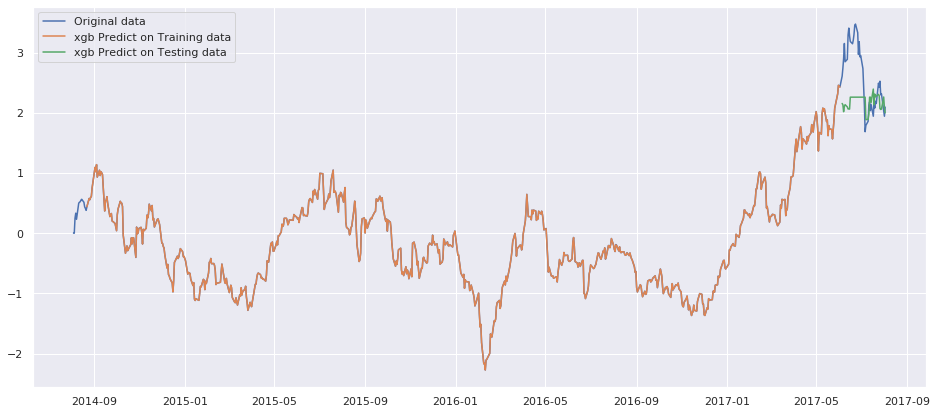

In [52]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_dataset, label='Original data')
# plt.plot(tesla_stocks.Date, Zero_y_pred, label='Zero Rule predict on all data')
# plt.plot(tesla_stocks.Date[14:-7], mvAve, label='Moving_average predict on all data')


if enable_model_list['lstm']:
    model = metric_model(LSTM_train_score, X_train, y_train, X_test, y_test)
    training, testing = encode_data2plot(model, X_train, X_test)
    plt.plot(tesla_stocks.Date, training, label='lstm Predict on Training data')
    plt.plot(tesla_stocks.Date, testing, label='lstm Predict on Testing data')
    
if enable_model_list['conv1d']:
    model = metric_model(Conv1d_train_score, X_train, y_train, X_test, y_test)
    training, testing = encode_data2plot(model, X_train, X_test)
    plt.plot(tesla_stocks.Date, training, label='conv1d Predict on Training data')
    plt.plot(tesla_stocks.Date, testing, label='conv1d Predict on Testing data')


if enable_model_list['xgb']:
    model = metric_model(XGB_train_score, red_X_train, red_y_train, red_X_test, red_y_test)
    training, testing = encode_data2plot(model, red_X_train, red_X_test)
    plt.plot(tesla_stocks.Date, training, label='xgb Predict on Training data')
    plt.plot(tesla_stocks.Date, testing, label='xgb Predict on Testing data')
    

plt.legend()
plt.show()

## Practice
1. 把Open、High、Low、Close跟Volume都當Feature